In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
import random
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import lightgbm as lgb
import xgboost as xg
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from tqdm.notebook import trange
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def RMSE(y_test,y_pred):
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)
    return RMSE

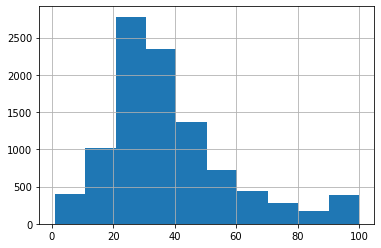

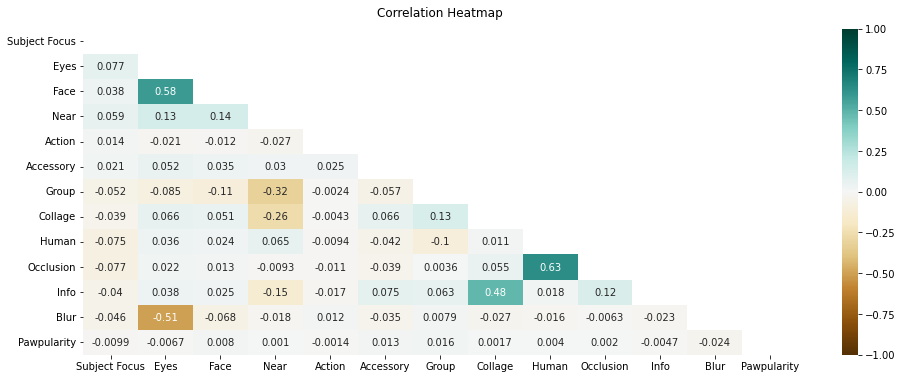

In [3]:

train_raw=pd.read_csv("../input/petfinder-pawpularity-score/train.csv")

train_raw["Pawpularity"].hist()
train_raw["Pawpularity"].describe()

test_raw=pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
# p=[["name"][0][1]]
# for feature in train_raw.columns:
#     if feature != "Pawpularity":
#         print(train_raw.groupby(feature).mean()["Pawpularity"])
# print(train_raw.head())


plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(train_raw.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_raw.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

test_raw=pd.read_csv("../input/petfinder-pawpularity-score/test.csv")

In [4]:
#split independent variables and dependent variables
X=train_raw.iloc[:,1:-1]
y=train_raw.iloc[:,-1]

#split into subtraining dataset and subtest dataset. Test size is 0.3
X_train, X_test, y_train, y_test = train_test_split(
               X, y, test_size=0.3, random_state=109)


In [5]:
#Linear Regression
#utilize best sbuset search
def fit_linear_reg(X_train,y_train,X_test, y_test):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X_train,y_train)
    y_pred=model_k.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = math.sqrt(MSE)
    return RMSE
    


#Initialization variables
k = 11
RMSE_list, feature_list = [],[]
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in trange(1,len(X_train.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_linear_reg(X_train[list(combo)],y_train, X_test[list(combo)],y_test)   #Store temp result 
        RMSE_list.append(tmp_result)                  #Append lists
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RMSE': RMSE_list,'features':feature_list})

df_min = df[df.groupby('numb_features')['RMSE'].transform(min) == df['RMSE']]
display(df_min.head(4))


# reg = LinearRegression().fit(X, y)
# print(reg.score(X, y))
# print(reg.coef_)
# print(reg.intercept_)



# X_test=test_raw.iloc[:,1:]
# y_test=reg.predict(X_test)

# sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
# # submission=pd.DataFrame({"Id":test_raw['Id'],"Pawpularity":y_test})
# submission = sample_submission.copy()
# submission.iloc[:,1] = y_test
# submission.to_csv("./submission.csv",index=False,float_format='%.2f')
# submission
# #Public score: 20.49364 

Loop...:   0%|          | 0/12 [00:00<?, ?it/s]

,numb_features,RMSE,features
11,1,20.546050,"(Blur,)"
32,2,20.537754,"(Eyes, Blur)"
167,3,20.534629,"(Eyes, Group, Blur)"
552,4,20.532657,"(Eyes, Accessory, Group, Blur)"


In [6]:
lr_features=[]
for i in range(4):
    lr_features.append(df_min[df_min['numb_features']==4]['features'].to_list()[0][i])
#fit linear regression with 4 features selected by best subset search
X_train_lr = X_train[lr_features]
linear_reg = LinearRegression()
linear_reg.fit(X_train_lr, y_train)
y_pred_lr = linear_reg.predict(X_test[lr_features])
RMSE(y_test,y_pred_lr)

# linear regression output
lr_output=linear_reg.predict(test_raw[lr_features])

In [7]:
test_raw

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f,1,0,1,0,0,0,0,0,1,0,0,1


In [8]:
#Decision tree would be better?

parameter_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12]}


dt_grid_search = GridSearchCV(DecisionTreeRegressor(random_state=109), param_grid=parameter_grid, scoring="neg_root_mean_squared_error")
dt_grid_search.fit(X_train, y_train)

print('Best score: {}'.format(dt_grid_search.best_score_))
print('Best parameters: {}'.format(dt_grid_search.best_params_))

DT_regressor = dt_grid_search.best_estimator_
y_pred = DT_regressor.predict(X_test)
RMSE(y_test,y_pred)

#decision tree output 
dt_output = DT_regressor.predict(test_raw.iloc[:,1:])

# DT_regressor = DecisionTreeRegressor(random_state=0)
# DT_regressor.fit(X_train,y_train)
# # cross_val_score(DT_regressor, X, y, cv=10)
# # cross_val_predict(DT_regressor, X, y, cv=10)
# y_pred=DT_regressor.predict(X_test)

# # from sklearn.metrics import mean_squared_error
# # import math
 
# RMSE(y_test,y_pred)

# perm_importance = permutation_importance(DT_regressor, X_train, y_train)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Decision Tree Permutation Feature Importance")
# plt.show()
# sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
# # submission=pd.DataFrame({"Id":test_raw['Id'],"Pawpularity":y_test})
# submission = sample_submission.copy()
# submission.iloc[:,1] = y_test
# submission.to_csv("./submission.csv",index=False,float_format='%.2f')

Best score: -20.580296534767264
Best parameters: {'max_depth': 3, 'max_features': 8}


In [9]:
np.arange(0,200,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190])

In [10]:
# #try random forest
# parameter_grid = {'n_estimators': np.arange(1,100,10),
#                   'max_depth': np.arange(1,10),
#                  'min_samples_leaf':[1, 2, 3, 4, 5],
#                  'min_samples_split':[ 2, 3, 4, 5]}


# rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=109), param_grid=parameter_grid, scoring="neg_root_mean_squared_error")
# rf_grid_search.fit(X_train, y_train)

# print('Best score: {}'.format(rf_grid_search.best_score_))
# print('Best parameters: {}'.format(rf_grid_search.best_params_))

# # Best parameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 21}
# rf_regressor = rf_grid_search.best_estimator_
# y_pred = rf_regressor.predict(X_test)
# RMSE(y_test,y_pred)

#random forest output
rf_regressor = RandomForestRegressor(
    random_state=109, max_depth = 4, n_estimators=21, min_samples_leaf=2, min_samples_split=2).fit(X_train, y_train)
rf_output=rf_regressor.predict(test_raw.iloc[:,1:])

#random forest 
# rf_regressor = RandomForestRegressor(max_depth=2, random_state=0)
# rf_regressor.fit(X_train, y_train)
# y_pred=rf_regressor.predict(X_test)
# RMSE(y_test,y_pred)
# from sklearn.metrics import mean_squared_error
# import math
 
# MSE = mean_squared_error(y_val, y_val_pred)
# RMSE = math.sqrt(MSE)
# RMSE
# importances = rf_regressor.feature_importances_
# sorted_idx = rf_regressor.feature_importances_.argsort()

# plt.barh(X_test.columns[sorted_idx], rf_regressor.feature_importances_[sorted_idx])
# plt.xlabel("Random Forest Feature Importance")
# plt.show()

# perm_importance = permutation_importance(rf_regressor, X_train, y_train)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Random Forest Permutation Feature Importance")
# plt.show()


# sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
# # submission=pd.DataFrame({"Id":test_raw['Id'],"Pawpularity":y_test})
# submission = sample_submission.copy()
# submission.iloc[:,1] = y_test
# submission.to_csv("./submission.csv",index=False,float_format='%.2f')

In [11]:
# # score_lt = []

# # 每隔10步建立一个随机森林，获得不同n_estimators的得分
# for i in range(5,21,1):
#     rfc = RandomForestRegressor(n_estimators=i+1
#                                 ,random_state=109)
#     score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = "neg_root_mean_squared_error").mean()
#     score_lt.append(score)
# score_max = max(score_lt)
# print('最大得分：{}'.format(score_max),
#       '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# # 绘制学习曲线
# x = np.arange(5,21,1)
# plt.subplot(111)
# plt.plot(x, score_lt, '.-')
# plt.show()

[05:30:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


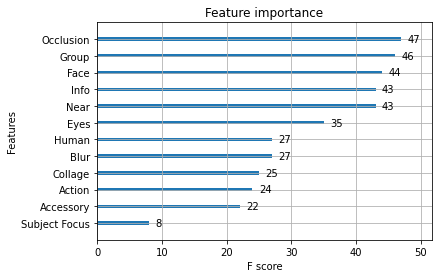

In [12]:
#will xgboost work for this project?

xgb_r = xg.XGBRegressor(objective ='reg:linear',seed = 123, n_estimators = 10)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred = xgb_r.predict(X_test)

plot_importance(xgb_r)
RMSE(y_test, y_pred)

#xgb output
xgb_output = xgb_r.predict(test_raw.iloc[:,1:])

Starting training...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 15.5376	valid_0's l2: 441.07
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 15.5326	valid_0's l2: 440.987
[3]	valid_0's l1: 15.5318	valid_0's l2: 441.028
[4]	valid_0's l1: 15.5314	valid_0's l2: 441.087
[5]	valid_0's l1: 15.5277	valid_0's l2: 440.98
[6]	valid_0's l1: 15.5201	valid_0's l2: 440.799
[7]	valid_0's l1: 15.5167	valid_0's l2: 440.747
[8]	valid_0's l1: 15.5117	valid_0's l2: 440.674
[9]	valid_0's l1: 15.5056	valid_0's l2: 440.534
[10]	valid_0's l1: 15.5019	valid_0's l2: 440.504
[11]	valid_0's l1: 15.5033	valid_0's l2: 440.479
[1

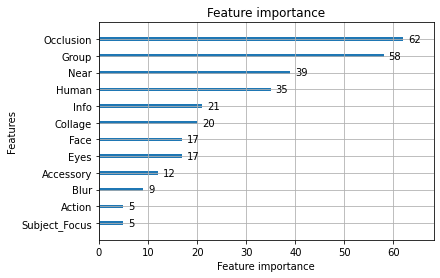

In [13]:
#light GBM regressor
from sklearn.model_selection import train_test_split
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(
           X, y, test_size=0.2, random_state=109)

X_train, X_val, y_train, y_val = train_test_split(
    X_subtrain, y_subtrain, test_size=0.25, random_state=109)


params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

lgb.plot_importance(gbm)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_subtest, num_iteration=gbm.best_iteration)

RMSE(y_subtest, y_pred)

#light gbm output
lgbm_output=gbm.predict(test_raw.iloc[:,1:])

In [14]:
#try KNN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=109)


# best_k={}
# for k in range(1,100,1):
#     knn = KNeighborsRegressor(n_neighbors=k)
#     knn.fit(X_train, y_train)
#     y_pred = knn.predict(X_test)
#     MSE = mean_squared_error(y_test, y_pred)
#     RMSE = math.sqrt(MSE)
#     best_k[RMSE] = k
# print(best_k)
# best_value = k = min(best_k.keys())
# k = best_k[best_value]
k = 87

knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
RMSE(y_test, y_pred)


knn_output=knn.predict(test_raw.iloc[:,1:])


In [15]:
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
submission = sample_submission.copy()
submission.iloc[:,1] = (knn_output+lgbm_output+xgb_output+rf_output+dt_output+lr_output)/6
submission.to_csv("./submission.csv",index=False,float_format='%.2f')
submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,38.027738
1,43a2262d7738e3d420d453815151079e,39.032593
2,4e429cead1848a298432a0acad014c9d,44.292662
3,80bc3ccafcc51b66303c2c263aa38486,36.286773
4,8f49844c382931444e68dffbe20228f4,33.976197
5,b03f7041962238a7c9d6537e22f9b017,41.339522
6,c978013571258ed6d4637f6e8cc9d6a3,39.766293
7,e0de453c1bffc20c22b072b34b54e50f,35.967624
